In [1]:
from google.colab import files

uploaded = files.upload()
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jamesnogra/face-mask-usage

In [4]:
from zipfile import ZipFile

face_mask_zip = 'face-mask-usage.zip'
zip_ = ZipFile(face_mask_zip, 'r')
zip_.extractall()
zip_.close()

In [5]:
import os

correct_mask = os.listdir('fully_covered')
without_mask = os.listdir('not_covered')
incorrect_mask = os.listdir('partially_covered')

In [6]:
img_w, img_h = 64, 64
X, y = [], []

In [7]:
import numpy as np
from PIL import Image

# converting image greyscale to rgb
for i in correct_mask:
  img = Image.open('fully_covered/' + i).convert('RGB')
  img = img.resize((img_w,img_h))
  X.append(np.asarray(img))
  y.append(0)

In [8]:
for i in without_mask:
  img = Image.open('not_covered/' + i).convert('RGB')
  img = img.resize((img_w,img_h))
  X.append(np.asarray(img))
  y.append(1)

In [9]:
for i in incorrect_mask:
  img = Image.open('partially_covered/' + i).convert('RGB')
  img = img.resize((img_w,img_h))
  X.append(np.asarray(img))
  y.append(2)

In [10]:
X = np.asarray(X)
y = np.asarray(y)

In [11]:
X = X.astype('float32')
X = X / 255.0
X[0]

array([[[0.58431375, 0.58431375, 0.58431375],
        [0.58431375, 0.58431375, 0.58431375],
        [0.58431375, 0.58431375, 0.58431375],
        ...,
        [0.59607846, 0.59607846, 0.59607846],
        [0.5803922 , 0.5803922 , 0.5803922 ],
        [0.5882353 , 0.5882353 , 0.5882353 ]],

       [[0.6       , 0.6       , 0.6       ],
        [0.59607846, 0.59607846, 0.59607846],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        ...,
        [0.5921569 , 0.5921569 , 0.5921569 ],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        [0.5921569 , 0.5921569 , 0.5921569 ]],

       [[0.58431375, 0.58431375, 0.58431375],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        ...,
        [0.5803922 , 0.5803922 , 0.5803922 ],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        [0.5882353 , 0.5882353 , 0.5882353 ]],

       ...,

       [[0.5803922 , 0.5803922 , 0.5803922 ],
        [0.58431375, 0.58431375, 0.58431375],
        [0.5803922 , 0

In [12]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, 3)
y[0]

array([1., 0., 0.], dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [14]:
print('training size: ', len(X_train))
print('validation size: ', len(X_valid))

training size:  4956
validation size:  551


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model = Sequential([
  Conv2D(64, 3, activation='relu', padding='same', input_shape=(img_w,img_h,3)),
  MaxPooling2D(2,2),
  Conv2D(128, 3, activation='relu', padding='same'),
  MaxPooling2D(2,2),
  Conv2D(128, 3, activation='relu', padding='same'),
  MaxPooling2D(2,2),
  Conv2D(256, 3, activation='relu', padding='same'),
  MaxPooling2D(2,2),
  Flatten(),
  Dropout(0.25),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import Callback

class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.98:
      self.model.stop_training = True

callbacks = MyCallback()

In [18]:
epochs = 25
batch_size = 64
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[callbacks]
)

Epoch 1/25
78/78 [==============================] - 107s 1s/step - loss: 0.6214 - accuracy: 0.7337 - val_loss: 0.3440 - val_accuracy: 0.8820
Epoch 2/25
78/78 [==============================] - 95s 1s/step - loss: 0.2793 - accuracy: 0.8993 - val_loss: 0.1845 - val_accuracy: 0.9510
Epoch 3/25
78/78 [==============================] - 96s 1s/step - loss: 0.1448 - accuracy: 0.9512 - val_loss: 0.1471 - val_accuracy: 0.9510
Epoch 4/25
78/78 [==============================] - 95s 1s/step - loss: 0.0886 - accuracy: 0.9728 - val_loss: 0.0982 - val_accuracy: 0.9710
Epoch 5/25
78/78 [==============================] - 95s 1s/step - loss: 0.0611 - accuracy: 0.9800 - val_loss: 0.0918 - val_accuracy: 0.9782
Epoch 6/25
78/78 [==============================] - 95s 1s/step - loss: 0.0450 - accuracy: 0.9853 - val_loss: 0.1075 - val_accuracy: 0.9728
Epoch 7/25
78/78 [==============================] - 95s 1s/step - loss: 0.0348 - accuracy: 0.9871 - val_loss: 0.0688 - val_accuracy: 0.9819


In [19]:
loss = model.evaluate(X_valid, y_valid)
loss

18/18 [==============================] - 3s 160ms/step - loss: 0.0688 - accuracy: 0.9819


[0.06883811205625534, 0.9818511605262756]

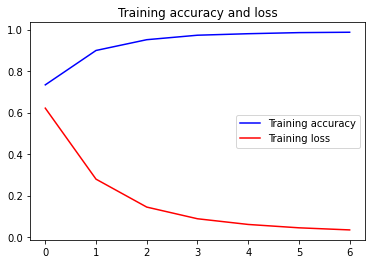

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy', color='b')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training accuracy and loss')
plt.legend()
plt.show()

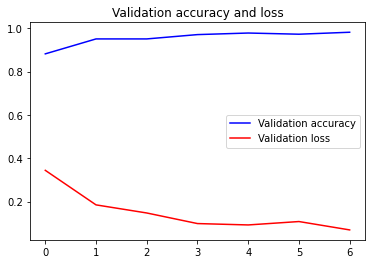

In [21]:
acc = history.history['val_accuracy']
loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Validation accuracy', color='b')
plt.plot(epochs, loss, 'r', label='Validation loss')
plt.title('Validation accuracy and loss')
plt.legend()
plt.show()

Saving test_correct.jpg to test_correct (1).jpg
test_correct.jpg
[[1. 0. 0.]]
ini orang patuh aturan


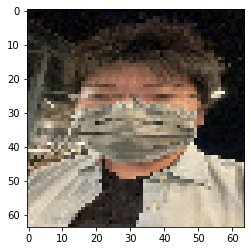

In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for files in uploaded.keys():
  path = files
  img = image.load_img(path, target_size = (img_w,img_h))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)

  print(files)
  print(classes)
  if classes[0][0] == 1:
    print('ini orang patuh aturan')
  elif classes[0][1] == 1:
    print('ini orang bego ga patuh aturan')
  elif classes[0][2] == 1:
    print('ini orang patuh tapi bego')

In [23]:
model.save('uasaiV1.h5')